# Set up

In [2]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format

import warnings
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [3]:
filepath_data = "C:\\Users\\15126\\Desktop\\Chicago\\Autumn\\Portfolio Management\\finm36700\\multi_asset_etf_data.xlsx"
info = pd.read_excel(filepath_data,sheet_name='descriptions') # information of asset classes indexed by ticker
info.set_index('ticker',inplace=True)

rets = pd.read_excel(filepath_data,sheet_name='total returns') # total returns of asset classes indexed by date
rets.set_index('Date',inplace=True)

In [4]:
symbol_list = info.index
rets = rets[symbol_list]

## Data

In [5]:
rets.drop(columns=['QAI'],inplace=True) # drop QAI due to complications related to optimal holding being a short position
# Setting risk-free rate as money market fund
TICK_RF = 'SHV'
rf = rets[TICK_RF]
retsx = rets.sub(rf,axis=0)
retsx.drop(columns=['SHV'],inplace=True)

# 1. Summary Statistics

### Calculate and display the mean and volatility of each asset’s excess return. (Recall we use volatility to refer to standard deviation.)

In [10]:
# Summary Statistics - Annualize monthly returns, volatility, and Sharpe ratio
annual_mean = retsx.mean()*12
annual_vol = retsx.std()*np.sqrt(12)
annual_sharpe = annual_mean/annual_vol

In [9]:
# Plot Summary Statistics in Table
summary_stats = pd.DataFrame({'Annualized Mean':annual_mean,
                              'Annualized Volatility':annual_vol,
                              'Annualized Sharpe Ratio':annual_sharpe})
display(summary_stats) # Display summary statistics

,Annualized Mean,Annualized Volatility,Annualized Sharpe Ratio
SPY,0.1281,0.1428,0.8971
EFA,0.0618,0.1509,0.4094
EEM,0.0293,0.1762,0.1665
PSP,0.0926,0.2134,0.4338
HYG,0.0414,0.0759,0.5449
DBC,-0.0053,0.1666,-0.0318
IYR,0.0749,0.1687,0.4441
IEF,0.0164,0.0634,0.2586
BWX,-0.0077,0.0828,-0.0932
TIP,0.0205,0.0511,0.4011


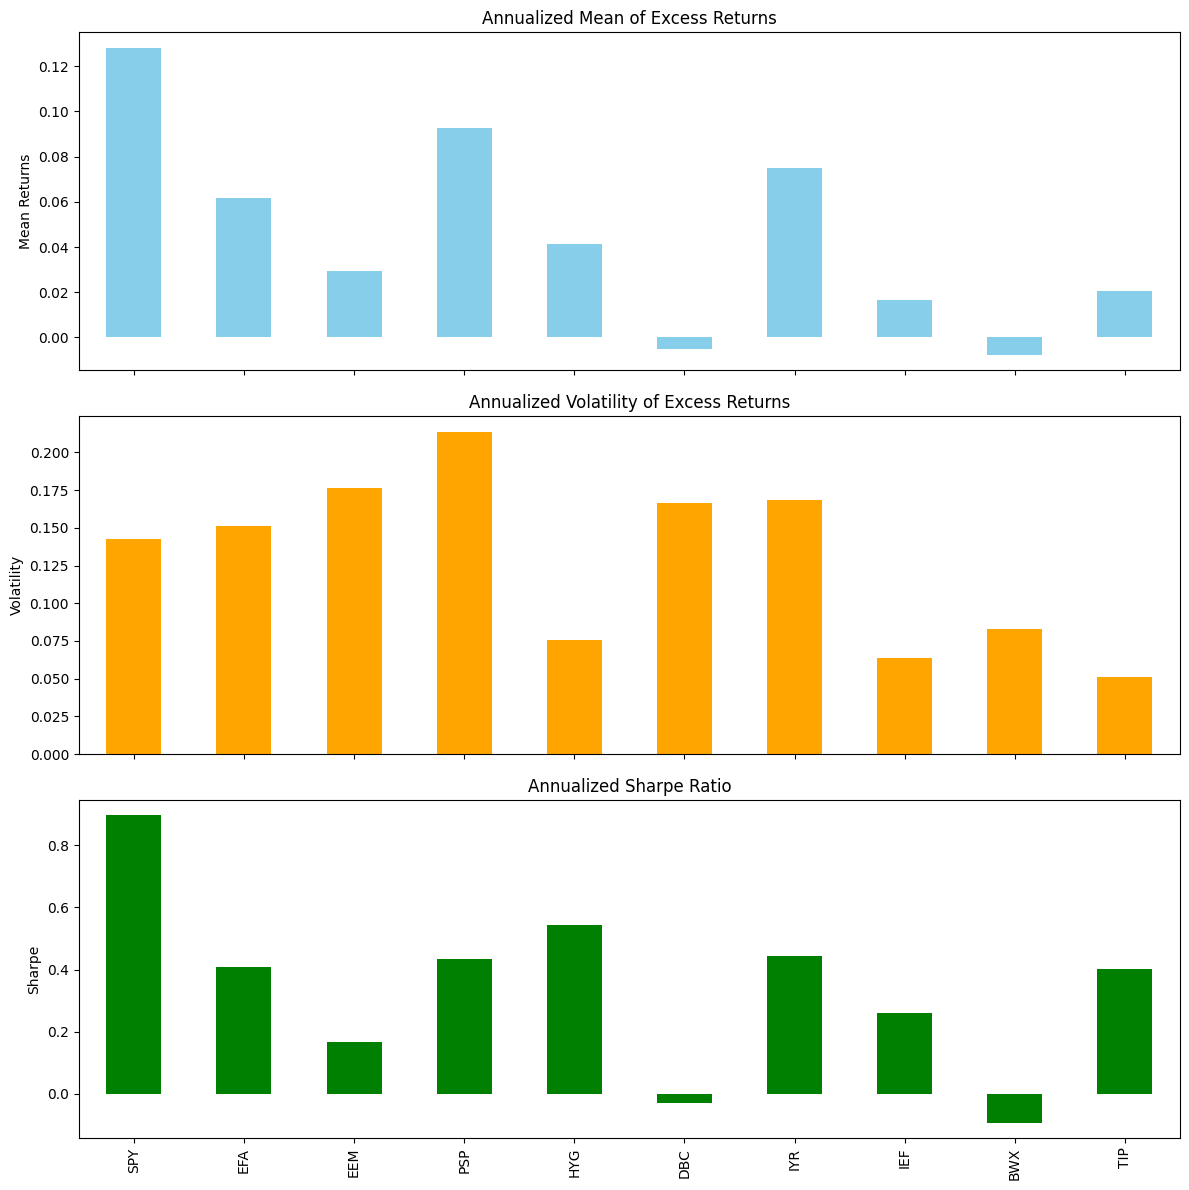

In [14]:
# Plot Summary Statistics in Three Bar Charts
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

summary_stats["Annualized Mean"].plot(kind="bar", ax=axes[0], color="skyblue")
axes[0].set_title("Annualized Mean of Excess Returns")
axes[0].set_ylabel("Mean Returns")

summary_stats["Annualized Volatility"].plot(kind="bar", ax=axes[1], color="orange")
axes[1].set_title("Annualized Volatility of Excess Returns")
axes[1].set_ylabel("Volatility")

summary_stats["Annualized Sharpe Ratio"].plot(kind="bar", ax=axes[2], color="green")
axes[2].set_title("Annualized Sharpe Ratio")
axes[2].set_ylabel("Sharpe")

plt.tight_layout()
plt.show()

### Which assets have the best and worst Sharpe ratios?

In [18]:
min_sharpe_asset = summary_stats['Annualized Sharpe Ratio'].idxmin() # Worst Sharpe ratio asset
max_sharpe_asset = summary_stats['Annualized Sharpe Ratio'].idxmax() # Best Sharpe ratio asset
print(min_sharpe_asset)
print(max_sharpe_asset)

BWX
SPY


Typically, an asset with a Sharpe ratio above 1 is considered strong, as it indicates that returns are high relative to risk. Conversely, a low or negative Sharpe ratio suggests that the asset is delivering little to no compensation for the risk taken—in fact, negative values imply that the investor would have been better off holding a risk-free asset.

In this analysis, the asset with the lowest Sharpe ratio is BWX, with a value of –0.0932, meaning its returns did not justify its risk. By contrast, the asset with the highest Sharpe ratio is SPY, at 0.8971, which is below the threshold of 1 but still indicates comparatively better risk-adjusted performance than the other assets.

# 2. Descriptive Analysis

## Calculate the correlation matrix of the returns. Which pair has the highest correlation? And the lowest?

In [43]:
def plot_corr_matrix(
    df: pd.DataFrame,
    method: str = 'pearson',
    triangle: str = 'full',          # 'full' | 'upper' | 'lower'
    figsize: tuple = (10, 10),
    cmap: str = 'coolwarm',
    annot: bool = True,
    fmt: str = '.2f',
):
    """
    Plot a correlation-matrix heatmap with optional triangle masking,
    highlighting the global max (red) and min (blue) within the visible area.
    """
    # 1) compute corr and blank out the diagonal
    corr = df.corr(method=method).astype(float)
    np.fill_diagonal(corr.values, np.nan)

    # 2) build mask for upper/lower if requested
    if triangle == 'upper':
        mask = np.tril(np.ones_like(corr.values, dtype=bool), k=0)  # hide lower + diagonal
    elif triangle == 'lower':
        mask = np.triu(np.ones_like(corr.values, dtype=bool), k=0)  # hide upper + diagonal
    else:  # 'full'
        mask = None

    # 3) draw the heatmap
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        corr,
        mask=mask,
        annot=annot,
        fmt=fmt,
        cmap=cmap,
        ax=ax,
        square=True,
        cbar_kws={'shrink': 0.8}
    )

    # 4) find & highlight global max/min **within the visible region only**
    arr = corr.values.copy()
    if mask is not None:
        arr[mask] = np.nan  # ignore the hidden half when finding extrema

    # skip if everything is NaN (tiny frames)
    if np.isfinite(arr).any():
    # strongest correlation (max |corr|)
        mag = np.abs(arr)
        max_mag = np.nanmax(mag)
        max_positions = np.argwhere(mag == max_mag)
    # least correlated (closest to 0)
        min_mag = np.nanmin(mag)
        min_positions = np.argwhere(mag == min_mag)

    # Draw red box for strongest correlation
    for r, c in max_positions:
        ax.add_patch(plt.Rectangle((c, r), 1, 1,
                                   facecolor='red', alpha=0.25, zorder=4))
        ax.add_patch(plt.Rectangle((c, r), 1, 1,
                                   fill=False, edgecolor='red',
                                   linewidth=2, zorder=5))

    # Draw blue box for least correlation
    for r, c in min_positions:
        ax.add_patch(plt.Rectangle((c, r), 1, 1,
                                   facecolor='blue', alpha=0.25, zorder=4))
        ax.add_patch(plt.Rectangle((c, r), 1, 1,
                                   fill=False, edgecolor='blue',
                                   linewidth=2, zorder=5))


    ax.set_title(f"Correlation matrix ({triangle} triangle, method={method})")
    plt.tight_layout()
    return fig, ax

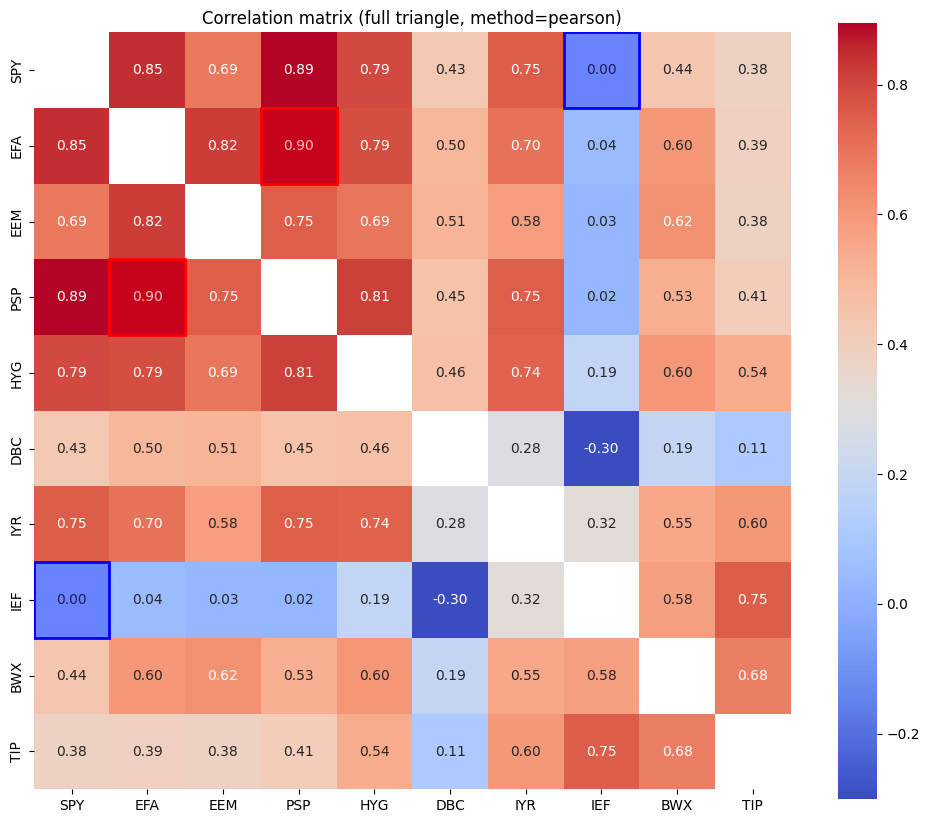

In [44]:
fig, ax = plot_corr_matrix(
    retsx,
    triangle='full',    # shows both upper & lower
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    figsize=(10, 10)
)


From the correlation map, we observe a range of relationships. The strongest correlation is between PSP and EFA (0.90), while the weakest correlation, closest to zero, is between IEF and SPY.

## How well have TIPS done in our sample? Have they outperformed domestic bonds? Foreign bonds?

In [45]:
# Function to calculate performance metrics
def performanceMetrics(returns,annualization=1):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean() * annualization
    metrics['Vol'] = returns.std() * np.sqrt(annualization)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annualization)

    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()

    return metrics

In [46]:
mets = performanceMetrics(retsx,annualization=12)
mets.sort_values('Sharpe',ascending=False).style.format('{:.1%}')

,Mean,Vol,Sharpe,Min,Max
SPY,12.8%,14.3%,89.7%,-12.9%,12.7%
HYG,4.1%,7.6%,54.5%,-10.4%,8.6%
IYR,7.5%,16.9%,44.4%,-20.0%,13.3%
PSP,9.3%,21.3%,43.4%,-27.8%,17.9%
EFA,6.2%,15.1%,40.9%,-14.5%,14.3%
TIP,2.1%,5.1%,40.1%,-6.7%,4.3%
IEF,1.6%,6.3%,25.9%,-4.7%,4.7%
EEM,2.9%,17.6%,16.7%,-17.9%,16.3%
DBC,-0.5%,16.7%,-3.2%,-17.7%,10.3%
BWX,-0.8%,8.3%,-9.3%,-6.9%,7.8%


From the table above, we can compare the mean returns of Treasury Inflation-Protected Securities (TIP) to domestic bonds (IEF): 2.1% vs. 1.6%. This suggests that TIP outperformed IEF while also exhibiting lower volatility and a higher Sharpe ratio. When compared to foreign bonds, which posted a –0.8% return, TIP performed significantly better.

# 3. The MV frontier

## Compute and display the weights of the tangency portfolio: $w^{(\text{tan})}$


In [ ]:
## Important functions needed to calculate tangency portfolio weights and perform sanity check
def sanity_check_tangency_from_returns(returns_df, extreme_factor: float = 3.0):
    """
    Compute on a returns DataFrame directly (e.g. excess returns).
    """
    cov     = returns_df.cov()
    mu      = returns_df.mean()

    invS    = np.linalg.inv(cov.values)
    one     = np.ones(mu.shape[0])

    A       = one @ invS @ one
    B       = one @ invS @ mu.values
    C       = mu.values @ invS @ mu.values

    mu_gmv  = B / A
    mu_tan  = C / B

    max_asset = np.max(np.abs(mu.values))
    threshold = extreme_factor * max_asset

    branch = 'upper (efficient)' if mu_gmv > 0 else 'lower'
    print(f"GMV mean (unscaled) : {mu_gmv:.6f} → tangency on the {branch} branch")
    print(f"Tangency mean       : {mu_tan:.6f}")
    print(f"Max |asset mean|    : {max_asset:.6f}")
    print(f"Threshold ({extreme_factor}×): {threshold:.6f}")

    if abs(mu_tan) >= threshold:
        print("🚩 EXTREME scaling: |μ_tan| exceeds threshold")
    else:
        print("✓ Scaling looks reasonable")


def tangency_weights(returns,dropna=True,scale_cov=1):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()

    return pd.DataFrame(weights, index=returns.columns)

In [ ]:
## Perform sanity check on tangency portfolio calculated from returns
sanity_check_tangency_from_returns(retsx)

GMV mean (unscaled) : 0.002250 → tangency on the upper (efficient) branch
Tangency mean       : 0.010710
Max |asset mean|    : 0.010678
Threshold (3.0×): 0.032035
✓ Scaling looks reasonable


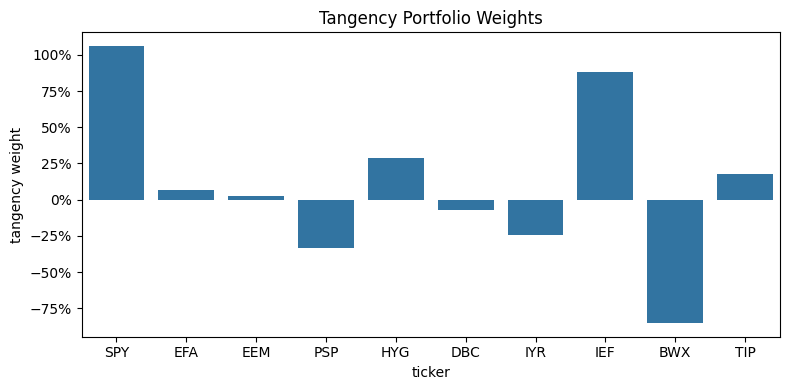

In [ ]:
## Compute and display the weights of the tangency portfolio: 

import matplotlib.ticker as mtick

wts = pd.DataFrame(index=retsx.columns)
wts['tangency'] = tangency_weights(retsx)

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=wts.index, y='tangency', data=wts, ax=ax)

# same formatter
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax.set_title('Tangency Portfolio Weights')
ax.set_ylabel('tangency weight')
ax.set_xlabel('ticker')
plt.tight_layout()
plt.show()